<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

2025 march - Gensim library has been updated. So, we neen reconfigure dependencies.

see more informations
https://github.com/Sinaptik-AI/pandas-ai/issues/1251

In [ ]:
!pip install --upgrade gensim
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

# Загрузка, очистка и визуализация данных

Пример - медицина - дата сет кардиология:
выгружено и предобработано MIMIC-IV-ECG/ Diagnostic Electrocardiogram Matched Subset v1.0

Столбец **Healthy_Status**: 0 = пациент, 1 - условно здоровый.

https://physionet.org/content/mimic-iv-ecg/1.0/

Декодированы метки времени, добавлен признак Healthy_Status

Полезная ссылка на понимание ЭКГ: https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

Полный датасет ECG_array_arrow_data.csv:

https://drive.google.com/file/d/1-Z2Yvcl7J8ZhdSp-MEqTHfzdrhbSdcdB/view?usp=share_link


In [ ]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

In [19]:
# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    #words = sentence.split()
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

In [20]:
print(full_df_filtered['report'][1])

Sinus rhythm Possible right atrial abnormality Borderline ECG


In [21]:
print(full_df_filtered['report'][1].lower().split())

['sinus', 'rhythm', 'possible', 'right', 'atrial', 'abnormality', 'borderline', 'ecg']


In [29]:
len(word_vec_example)

100

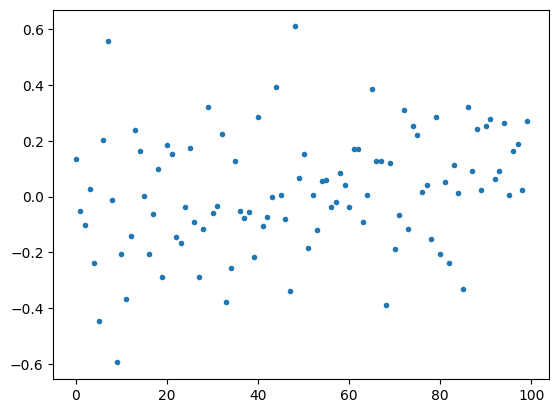

In [22]:
word_vec_example = get_sentence_embedding(full_df_filtered['report'][1])
plt.plot(word_vec_example,'.')

In [30]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)


# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.018588   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.018588   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.035797   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.017533   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.017533   

   rr_interval  p_onset  p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  \
0          659       40    128        170      258    518      81        77   
1          722       40    124        162      246    504      77        75   
2          600       40    130        162      244    474      79        72   
3          659       40    146        180      254    538      79        66   
6          952       40    146        198      282    598      24        80   

   t_axis  Healthy_Status  
0      79               0  
1      70               0  
2      77               1  
3      69               1  
6      20               1

In [ ]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

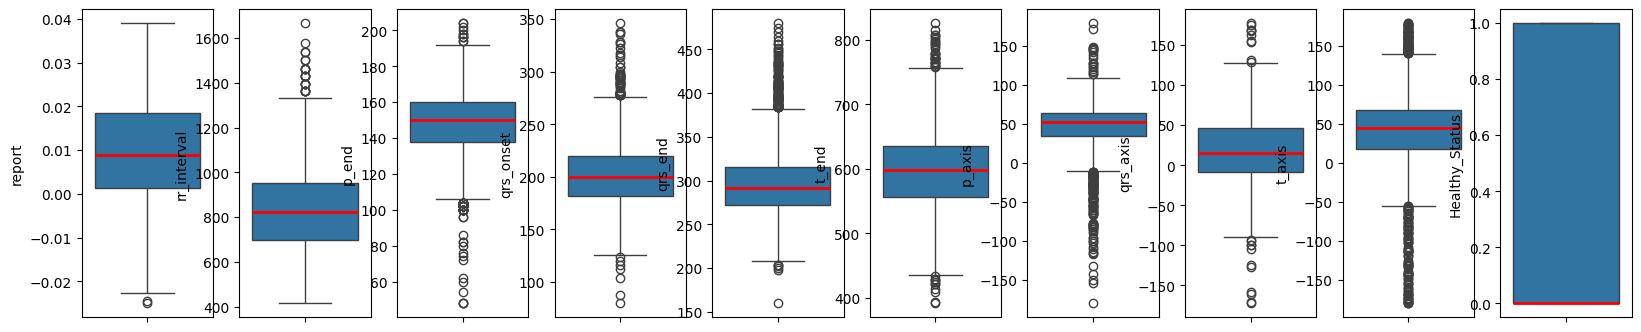

In [31]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

In [32]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)

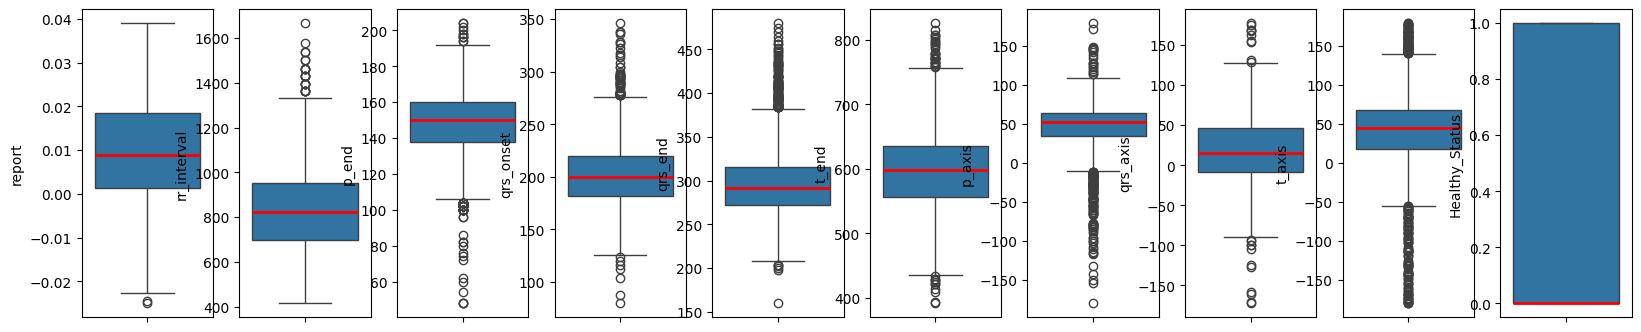

In [33]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})
    plt.tight_layout

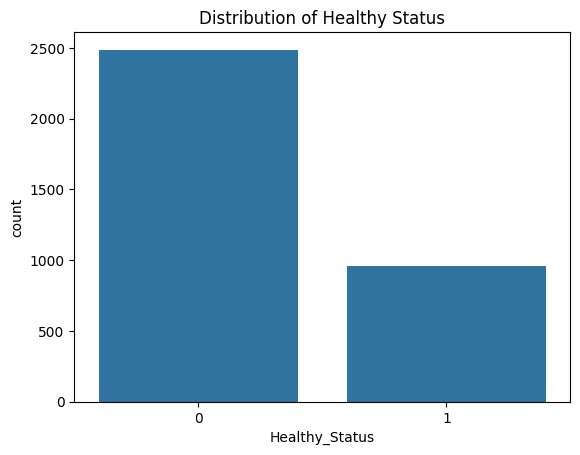

In [34]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

## Visualization examplpes

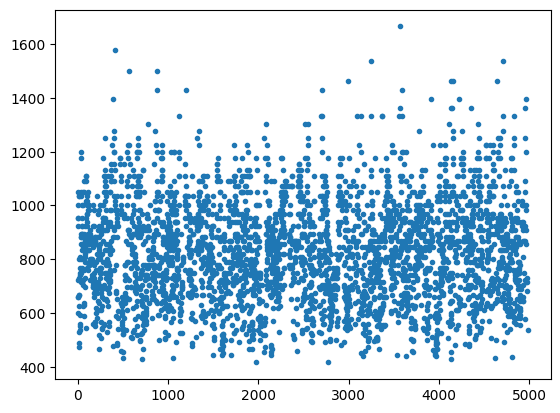

In [35]:
#example view
plt.plot(table_data['rr_interval'],'.')

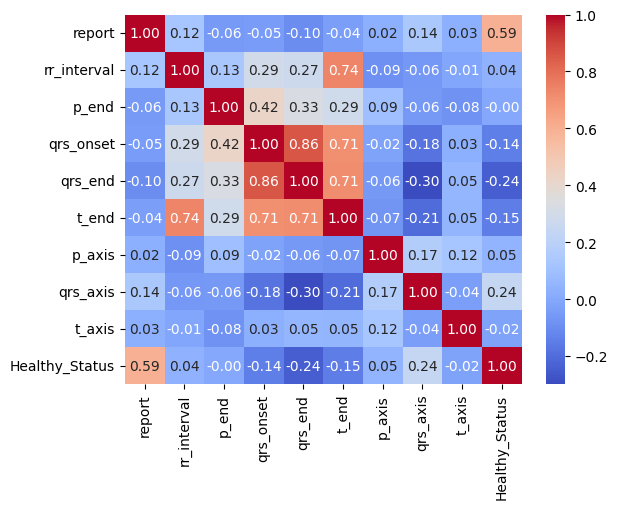

In [36]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

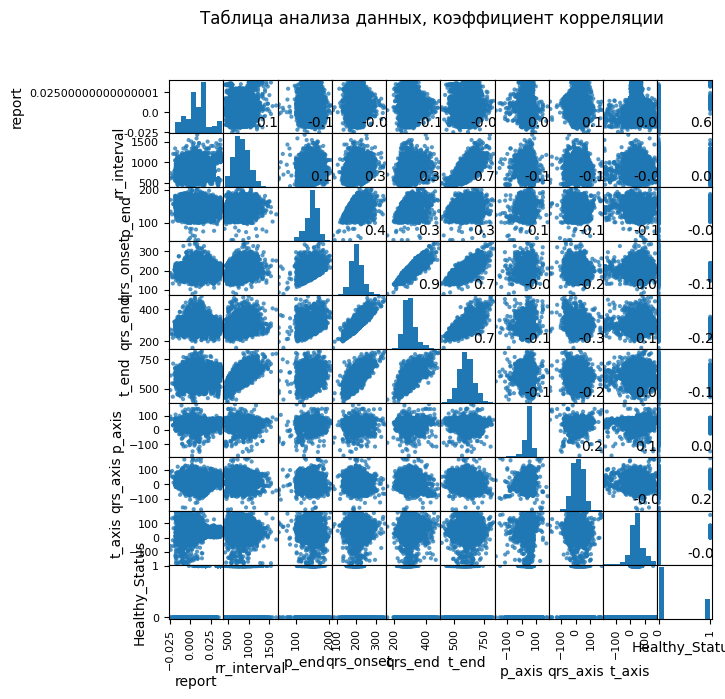

In [37]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

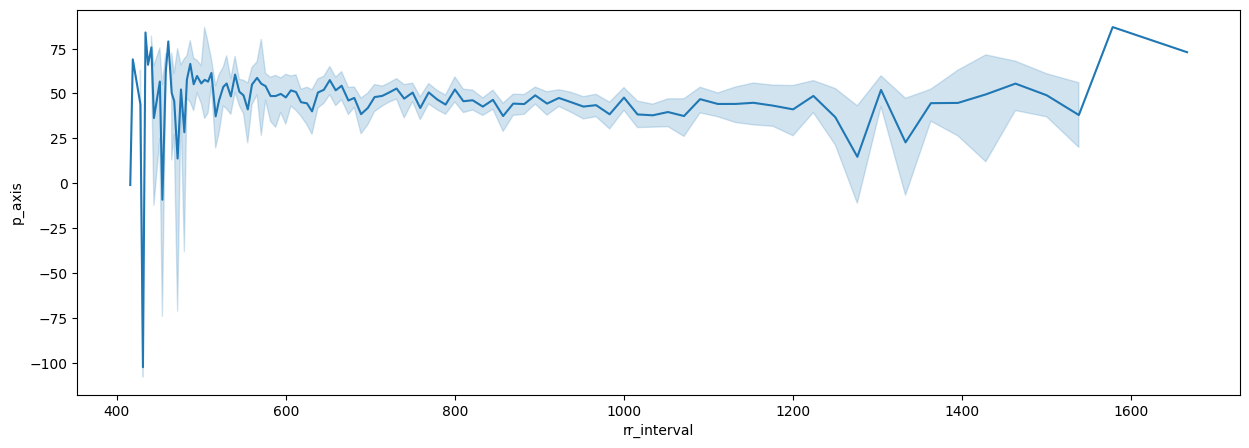

In [38]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

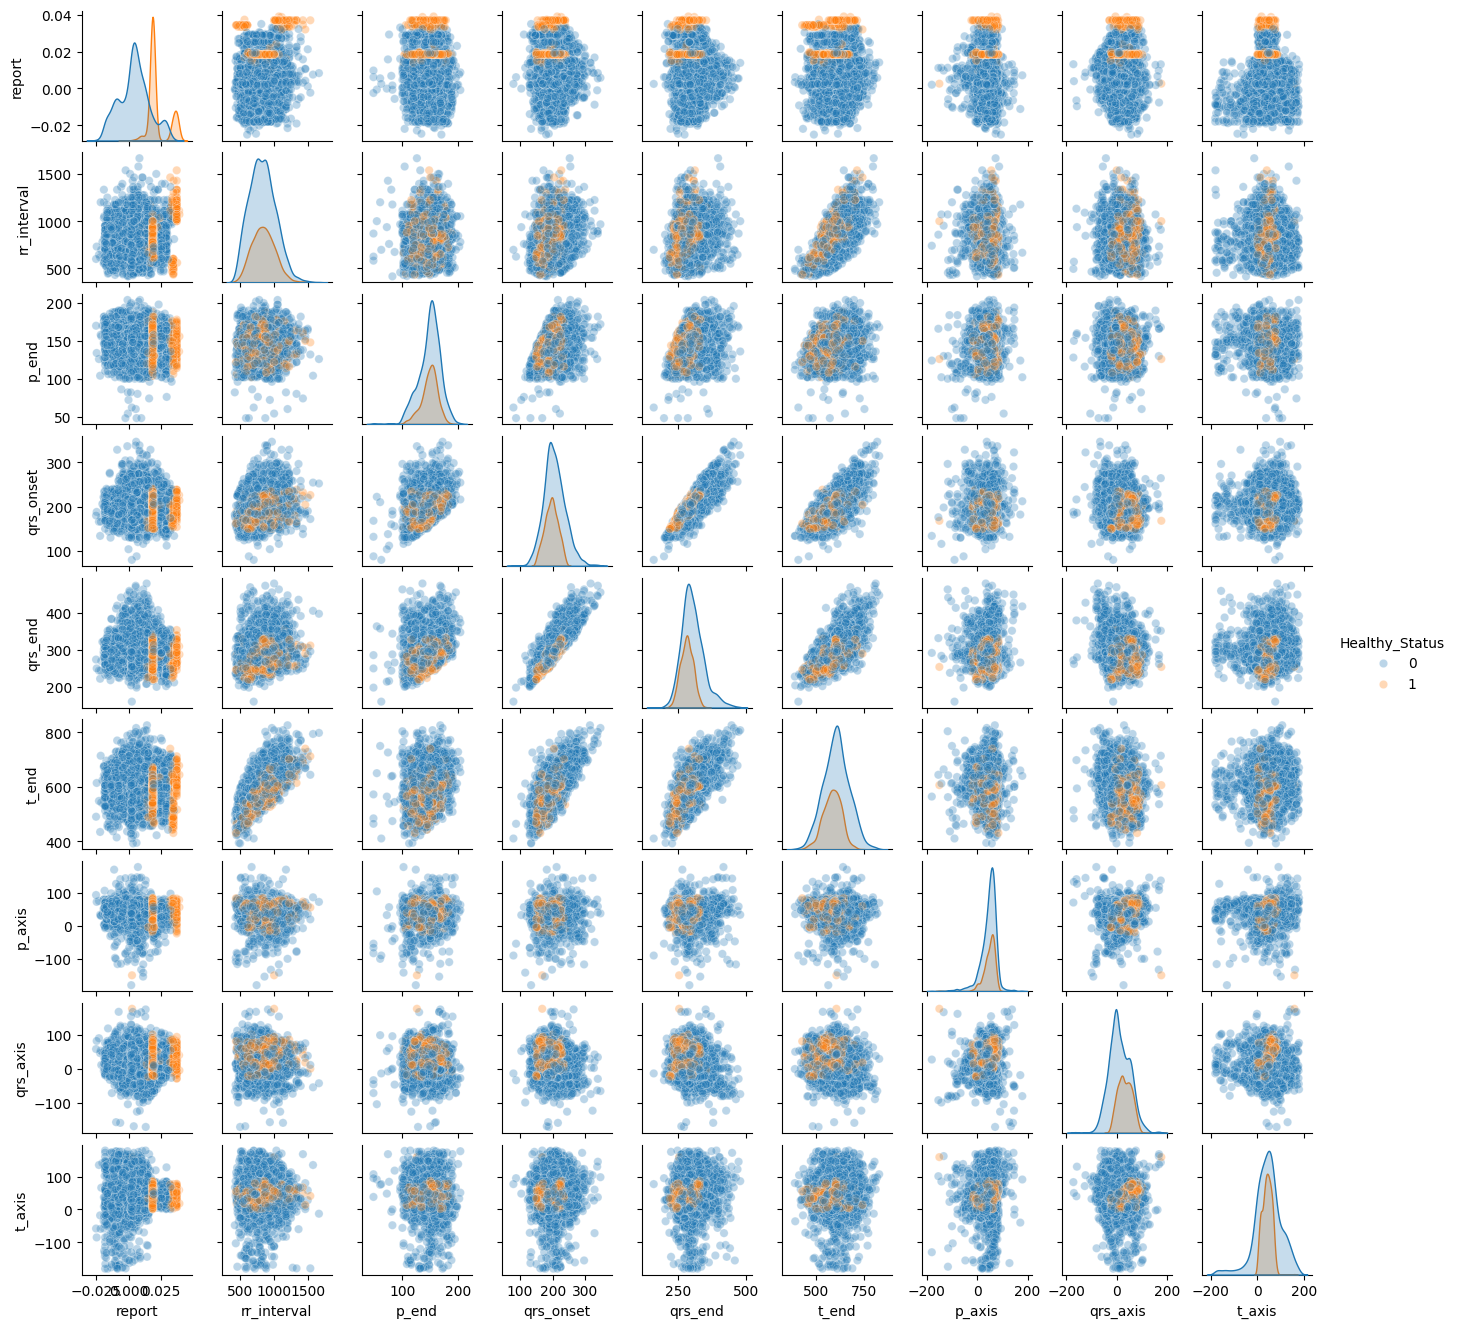

In [39]:
#labels = pd.DataFrame(table_data['Healthy_Status'])
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

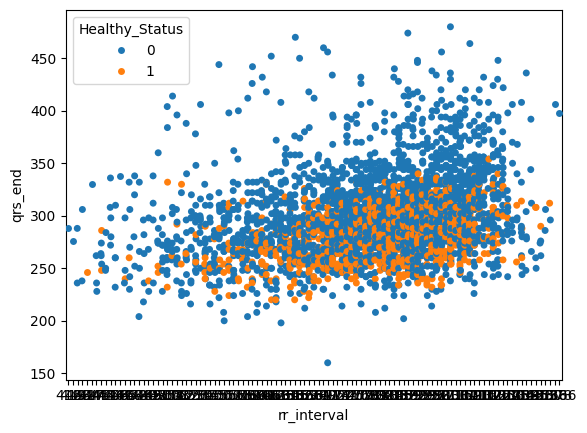

In [40]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


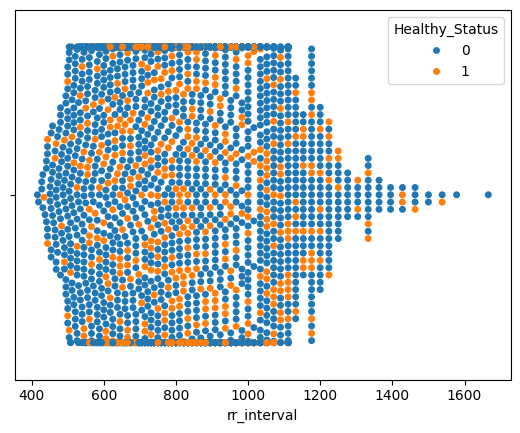

In [41]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

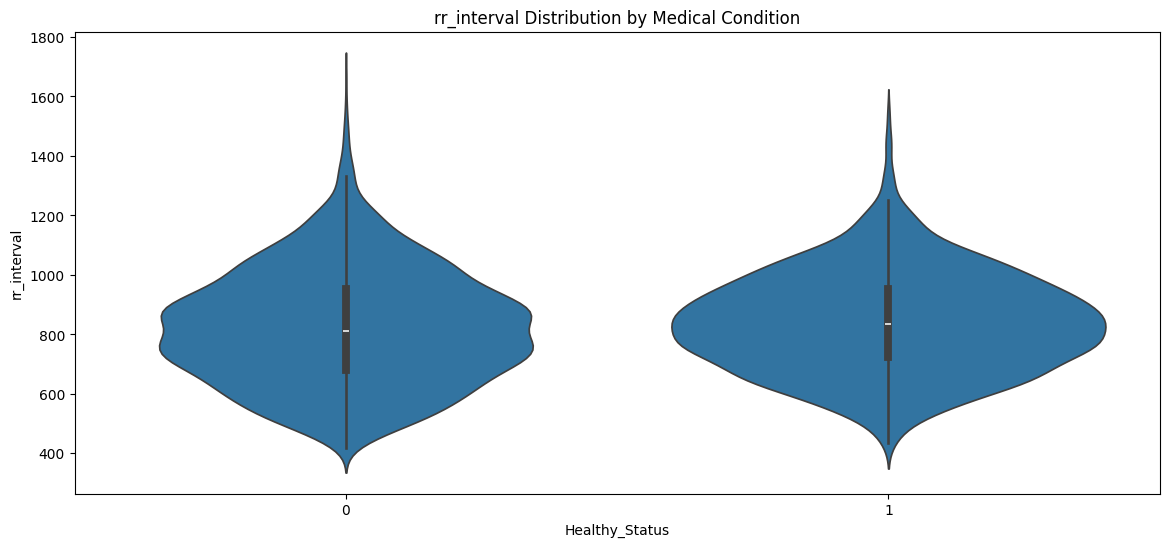

In [42]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

# Обработка данных: PCA, ICA, t-SNE

## PCA - principal component analysis

https://web.archive.org/web/20090528101113/http://www.chemometrics.ru/materials/textbooks/pca.htm

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [44]:
#table_data_pca = full_df_filtered
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [45]:
#cancer = load_breast_cancer()
# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(3448, 10) (3448, 2)


In [46]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34429121 0.13708176]
0.4813729713499031


In [47]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.14% explained variance
3 components at 61.24% explained variance
4 components at 73.06% explained variance
5 components at 82.25% explained variance
6 components at 90.24% explained variance


Text(0, 0.5, 'Second Principal Component')

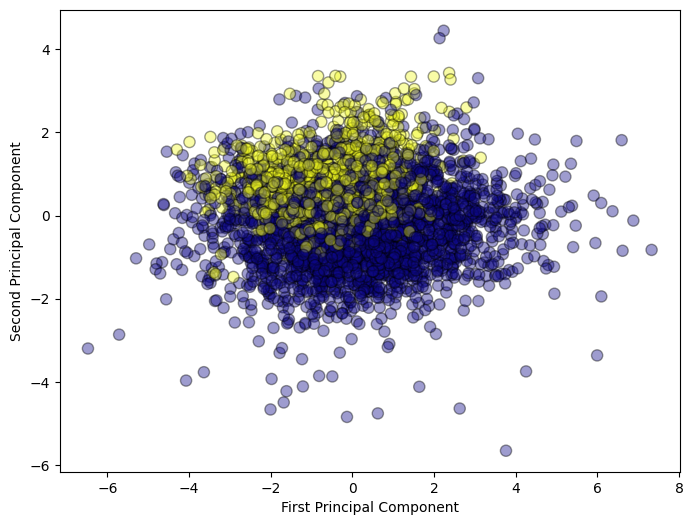

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<ipython-input-50-af0cb9cbdee1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.9, facecolor='white', head_width=.01)
<ipython-input-50-af0cb9cbdee1>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')


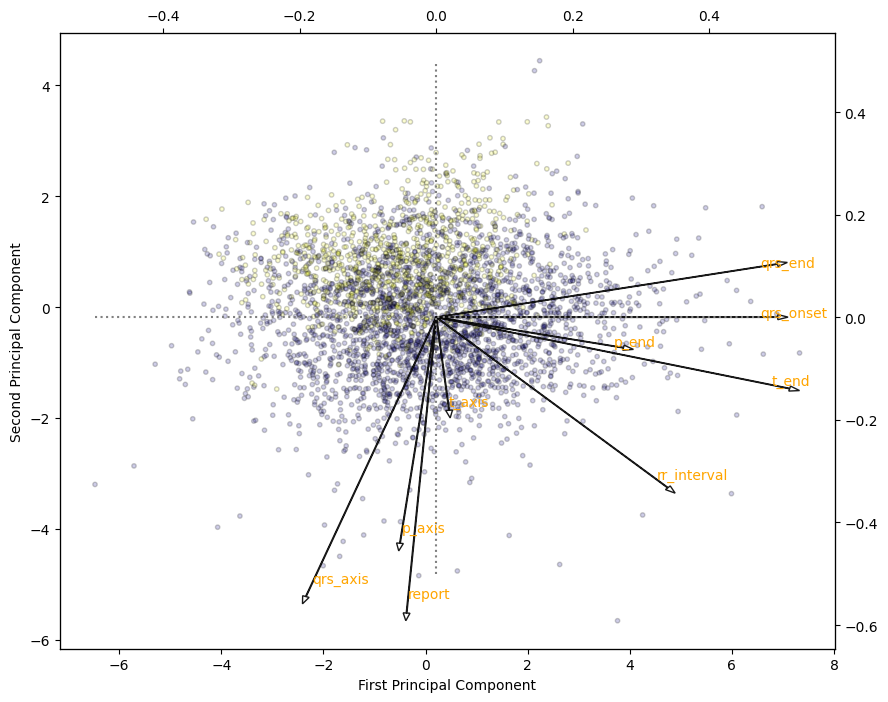

In [50]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.2, edgecolors='black', s=10);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.9, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

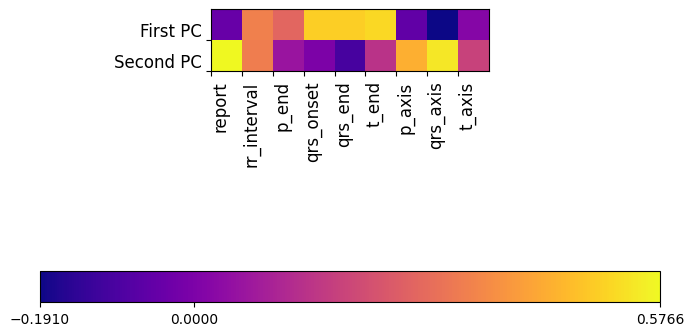

In [51]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

## t-SNE stohastic neighbor embedings

Text(0, 0.5, 'Second Principal Component')

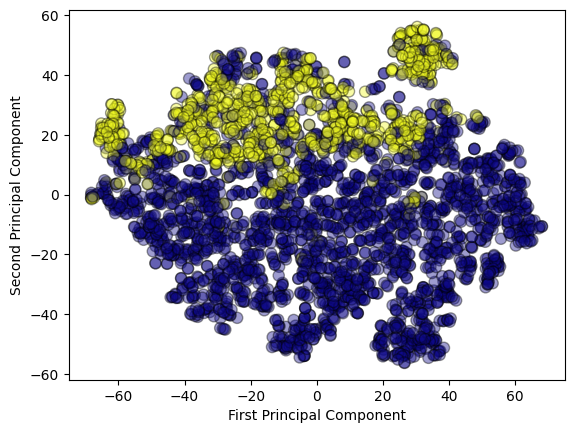

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [53]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 8.6 sec
Time code evaluation for perplexity=5 in 8.3 sec
Time code evaluation for perplexity=10 in 9.8 sec
Time code evaluation for perplexity=15 in 11 sec
Time code evaluation for perplexity=20 in 12 sec
Time code evaluation for perplexity=30 in 12 sec
Time code evaluation for perplexity=40 in 11 sec
Time code evaluation for perplexity=50 in 11 sec
Time code evaluation for perplexity=100 in 14 sec


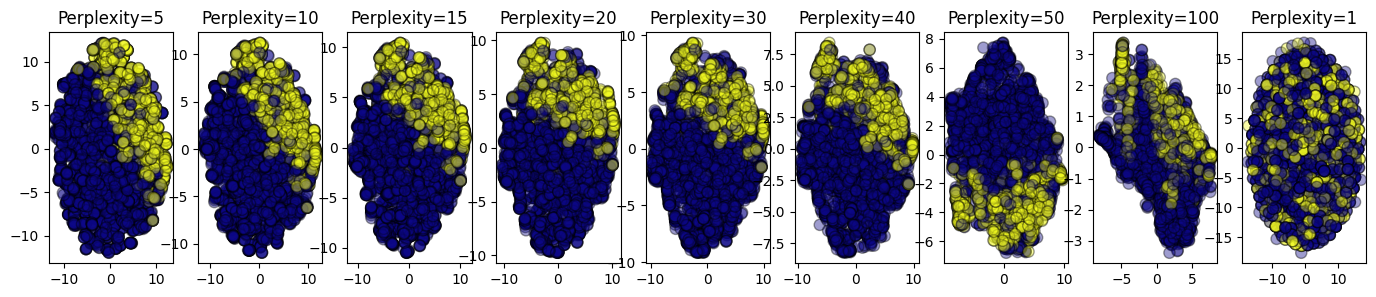

In [54]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]
#perplexities = [5, 10]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        max_iter=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")


## ICA independed component analysis

In [55]:
from sklearn.decomposition import FastICA

In [56]:
#Creating input data numpy array
#X = scaled_data.values

######################################################################
# Creating ICA object
ICA = FastICA(n_components=2)
scaled_data_ica = ICA.fit_transform(scaled_data)

Text(0, 0.5, 'Second Independed Component')

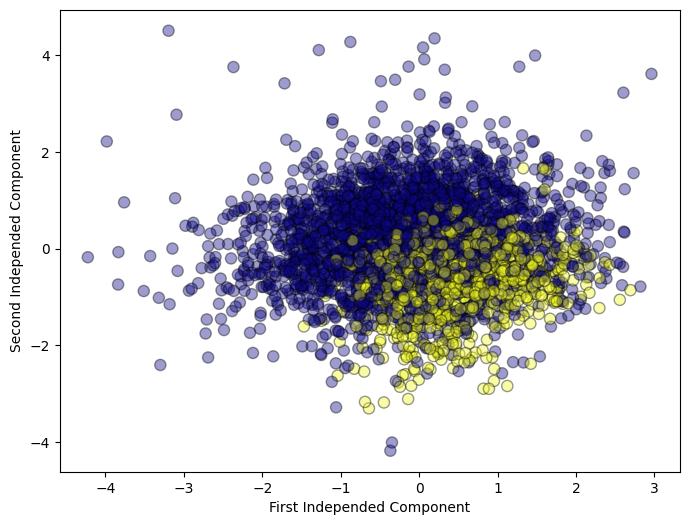

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(scaled_data_ica[:,0],
            scaled_data_ica[:,1],
            c=full_df_filtered['Healthy_Status'],
            cmap='plasma',
            alpha=0.4,
            edgecolors='black',
            s=65
            );
plt.xlabel('First Independed Component')
plt.ylabel('Second Independed Component')

# ML методы

## ML: GussianClassifier + описание классов и матрица ошибок

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

In [ ]:
# set the classification index of table
clf_index = 9

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

# AutoML examples

In [ ]:
# Убираем из датасета лишние столбцы
# Формируем датасет для AutoML методов
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()


## AutoML H2O

In [ ]:
!pip install h2o

In [ ]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# Инициализируем H2O
h2o.init()

In [ ]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(autoML_df)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

In [ ]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

In [ ]:
lb = automl.leaderboard
lb.head()

In [ ]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

In [ ]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

In [ ]:
automl.leader.model_performance(test)

In [ ]:
test_predict = automl.predict(test)

In [ ]:
out.varimp_plot()

In [ ]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

In [ ]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

In [ ]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

In [ ]:
# Завершение работы H2O
h2o.shutdown()

## AutoML AutoGluon

In [ ]:
!pip install autogluon --quiet
!pip install autogluon.tabular[lightgbm] --quiet

In [ ]:
import autogluon

In [ ]:
# Импортируем необходимые библиотеки
from autogluon.tabular import TabularPredictor

In [ ]:
autoML_df.head()

In [ ]:
# Разбиение на обучающую и тестовую выборки
random_seed = 17

# set the classification index of table
clf_index = 9

target = 'Healthy_Status'

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(
                                                        auto_X, auto_Y,
                                                        train_size=0.85,
                                                        random_state=random_seed,
                                                        stratify=auto_Y
                                                        )

# Создаем обучающий датафрейм
auto_train_df = auto_X_train.copy()
auto_test_df = auto_X_test.copy()
auto_train_df['Healthy_Status'] = auto_Y_train
auto_test_df['Healthy_Status'] = auto_Y_test

In [ ]:
# Создаем и обучаем модель
predictor = TabularPredictor(label='Healthy_Status', eval_metric='accuracy').fit(train_data=auto_train_df)

# Предсказание на тестовой выборке
y_pred = predictor.predict(auto_X_test)

In [ ]:
predictor.leaderboard(auto_test_df)

In [ ]:
!pip install autogluon.eda --quiet

In [ ]:
import autogluon.eda.auto as auto

In [ ]:
!pip install autogluon==1.2 --quiet

In [ ]:
# scikit-learn moves the check_pandas_support api,
# HAVE TO downgrade to scikit-learn <= 1.4.2 can solve the problem
!pip install scikit-learn==1.4.2

In [ ]:
auto.target_analysis(train_data=auto_train_df, label=target)

In [ ]:
auto.dataset_overview(train_data=auto_train_df,
                      test_data=auto_test_df,
                      label=target)

In [ ]:
predictor.quick_fit(auto_train_df, target_col=target, show_feature_importance_barplots=True)


## AutoML BlueCast

https://github.com/ThomasMeissnerDS/BlueCast.git

https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking

In [ ]:
!pip install bluecast --quiet

In [ ]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:
#  Пример загрузки данных
#table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)

#df = table_data

# Проверка формы набора данных
#print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 13

target = 'Healthy_Status'

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = autoML_df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)


In [ ]:
# Предобрабатываем данные

full_df = df

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered.head()

In [ ]:
full_df_filtered['report']

In [ ]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

In [ ]:
#Automatic feature type detection from BlueCast
print(feat_type_detector.date_columns)

In [ ]:
feat_type_detector.num_columns

In [ ]:
feat_type_detector.cat_columns

In [ ]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)

In [ ]:
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

In [ ]:
# show correlation to target
correlation_to_target(
    full_df_filtered.loc[:, feat_type_detector.num_columns],
      target,
      )

In [ ]:
#no_correlation = ["p_axis", "p_end", "t_axis"]

no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

In [ ]:
correlation_heatmap(train_data.loc[
            :, train_data.columns.values])

In [ ]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

In [ ]:
# show feature space after principal component analysis
plot_pca(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

In [ ]:
# show feature space after t-SNE
plot_tsne(autoML_df.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)

In [ ]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)

In [ ]:
# Detect leakage of numeric columns based on correlation
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

In [ ]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

In [ ]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 10
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

In [ ]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [ ]:
y_probs, test_preds = automl.predict(auto_X_test)

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(auto_Y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML Fedot

In [ ]:
!pip install -q scikit-learn==1.3.2

In [ ]:
!pip install -q --user scipy>=1.2.0

In [ ]:
!pip install fedot --quiet

In [ ]:
from fedot.api.main import Fedot
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

# Создаем и обучаем модель
#automl = BlueCast(class_problem="binary")
#automl.fit(auto_train_df, target_col="Healthy_Status")

In [ ]:


#from data.data import get_train_data, get_test_data

#train_features, train_target = get_train_data()
#test_features, test_target = get_test_data()

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', timeout=3)

# Fit model
obtained_pipeline = fedot_model.fit(features=auto_X, target=auto_Y)
obtained_pipeline.show()


In [ ]:

# Make predictions
predict = fedot_model.predict(auto_X_test)
predict_probs = fedot_model.predict_proba(auto_X_test)

In [ ]:
plt.plot(predict_probs,'.')

In [ ]:
len(predict_probs)

In [ ]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(predict_probs)):
  if predict_probs[i] > 0.5:
    predict_probs[i] = 1
  else:
    predict_probs[i] = 0


cm = confusion_matrix(auto_Y_test, predict_probs)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, predict_probs)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML LightAutoML

https://github.com/sb-ai-lab/LightAutoML


In [ ]:
!pip install shap --quiet

In [ ]:
!pip install -U lightautoml --quiet

In [ ]:
# Импорт библиотек для auto ml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

import pandas as pd
import numpy as np

In [ ]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 3 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Healthy_Status' # Target column name

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

In [ ]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('binary')

You can also optionally specify the following roles:

'numeric' - numerical feature

'category' - categorical feature

'text' - text data

'datetime' - features with date and time

'date' - features with date only

'group' - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

'drop' - features to drop, they will not be used in model building

'weights' - object weights for the loss and metric

'path' - image file paths (for CV tasks)

'treatment' - object group in uplift modelling tasks: treatment or control

In [ ]:
roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test_predictions = automl.predict(test_data).data
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

In [ ]:
test_data.head()

In [ ]:
# Порог отсечения - 0.5
for i in range(len(test_predictions)):
  if test_predictions[i] > 0.5:
    test_predictions[i] = 1
  else:
    test_predictions[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(test_data['Healthy_Status'], test_predictions)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

In [ ]:
print(automl.create_model_str_desc())

In [ ]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [ ]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
!ls tabularAutoML_model_report

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
%%time
test_predictions = automl_rd.predict(test_data)
#print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
plt.plot(test_predictions.data[:],'.')

In [ ]:
#print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

In [ ]:
explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

In [ ]:
# summary plot
import shap
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])

In [ ]:
train_data.head()

In [ ]:
# dependence plots
import matplotlib.pyplot as plt

feats = ["rr_interval", "qrs_axis"]
fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

for i, feat in enumerate(feats):
    shap.dependence_plot(feat, shap_values[1], test_data[explainer.used_feats],
                         show=False, ax=ax[i], interaction_index="qrs_onset")

In [ ]:
# individual force plot
shap.force_plot(explainer.expected_value[1], shap_values[1][0], test_data[explainer.used_feats].iloc[0], matplotlib=True)


## AutoML GAMA

https://openml-labs.github.io/gama/master/

In [ ]:
!pip install s

In [ ]:
!pip install gama --quiet

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
from gama import GamaClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
Y_auto = autoML_df['Healthy_Status'] # таргет
X_auto = autoML_df.iloc[:, :8] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(y_test))

In [ ]:
automl = GamaClassifier(max_total_time=60, store="nothing")
print("Starting `fit` which will take roughly 1 minutes.")
automl.fit(X_train, y_train)

In [ ]:
label_predictions = automl.predict(X_test)
probability_predictions = automl.predict_proba(X_test)

print('accuracy:', accuracy_score(y_test, label_predictions))
print('log loss:', log_loss(y_test, probability_predictions))
# the `score` function outputs the score on the metric optimized towards (by default, `log_loss`)
print('log_loss', automl.score(X_test, y_test))

In [ ]:
test_preds = label_predictions.data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

## AutoML PyCaret

https://habr.com/ru/companies/ods/articles/657525/

In [ ]:
!pip install pycaret --quiet

In [ ]:
#from pycaret.datasets import get_data

#  Набор данных о неплательщиках по кредиту
df = autoML_df

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 17

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_data = df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_data.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_data = df.drop(train_data.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_data.shape)


In [ ]:
# Задействуем волшебную функцию!
from pycaret.classification import *

# Функция setup инициализирует среду и создает конвейер преобразования
clf = setup(data=autoML_df, target="Healthy_Status", session_id=123)

In [ ]:
# Сравниваем различные модели в зависимости от их метрик производительности. По умолчанию модели сортируются по точности
best_model = compare_models(fold=5)

# Построение кривой AUC
plot_model(best_model, plot="auc")

In [ ]:
# Функция Tune model выполняет сеточный поиск для определения оптимальных параметров
tuned = tune_model(best_model)
plot_model(tuned, plot="confusion_matrix")

# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

In [ ]:
# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

# Прогнозирование на невидимых данных
predictions = predict_model(final_model, data=test_data)
predictions.head()

# ML GaussianNaiveBayes

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)

In [ ]:
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
#X1, y1 = table_data.iloc[:, :-1], table_data.iloc[:, -1]

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X1_train, y1_train)
nb_clf_pred_res = nb_clf.predict(X1_test)
nb_clf_accuracy = accuracy_score(y1_test, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

In [ ]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X1_train, y1_train)
sk_nb_clf_pred_res = sk_nb_clf.predict(X1_test)
sk_nb_clf_accuracy = accuracy_score(y1_test, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0, 6]
title1 = 'GaussianNB surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_nb_clf, feature_indexes, title1)

# MDS

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components = 2)
scaled_data_mds = mds.fit_transform(scaled_data)

plt.scatter(scaled_data_mds[:,0], scaled_data_mds[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_mds_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_mds_tsne[:,0], scaled_data_mds_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [ ]:

#scaled_data, data_table['Healthy_status'] = make_blobs(random_state = 10)
# n_clusters must be None if distance_threshold is not None
cls = AgglomerativeClustering(n_clusters = 5, affinity='euclidean',linkage='ward', distance_threshold=None)
cls_assignment = cls.fit_predict(scaled_data)

In [ ]:
Z = ward(scaled_data)
plt.figure(figsize=(17,5));
R = dendrogram(Z, truncate_mode='lastp', p=7, orientation='top', leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (truncated and grouped)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

https://stackoverflow.com/questions/54810800/how-to-get-a-list-of-all-leaves-under-a-node-in-a-dendrogram

In [ ]:
# put X in a dataframe
df = pd.DataFrame()
df['col1']=X[:,0]
df['col2']=X[:,1]

index=[]
for i in range(len(X)):
    elem = 'A' + str(i)
    index.append(elem)

df['index'] = index
print(df.shape)
df.head()

# retrieve elements in each cluster
label = fcluster(Z, 5, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst['index']  = df['index']
df_clst['label']  = label

# print them
for i in range(5):
   elements = df_clst[df_clst['label']==i+1]['index'].tolist()
   size = len(elements)
   print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))

In [ ]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(Z,5,criterion='maxclust')

In [ ]:
R

In [ ]:
R

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
linkage_matrix = sch.average(scaled_data)
rootnode, nodelist = sch.to_tree(linkage_matrix, rd=True)
leaves = sch.leaves_list(linkage_matrix)
print(linkage_matrix[3,:])
#sch.dendrogram(linkage_matrix);

In [ ]:
R

# Affinity propagation

In [ ]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import adjusted_rand_score

In [ ]:
def plot_connected_points(X, labels, centers, cmap):
    for i in range(len(X)):
        color = cmap(labels[i] / len(centers))
        plt.plot([X[i, 0], centers[labels[i], 0]], [X[i, 1], centers[labels[i], 1]], c=color, alpha=0.8)

In [ ]:
sk_ap = AffinityPropagation()
sk_ap_pred_res = sk_ap.fit_predict(scaled_data)
sk_ap_ari = adjusted_rand_score(table_data['Healthy_Status'], sk_ap_pred_res)
print(f'Adjusted Rand Score for sk AffinityPropagation: {sk_ap_ari}', '', sep='\n')
print('Number of clusters = ', np.max(sk_ap_pred_res))
#print('prediction', sk_ap_pred_res, sep='\n')

In [ ]:
plt.figure(figsize=(12, 5))

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=sk_ap_pred_res, cmap='rainbow', s=10)
plt.scatter(sk_ap.cluster_centers_[:, 0], sk_ap.cluster_centers_[:, 1], c='black', s=50)
plt.title('AffinityPropagation (scikit-learn)')
plt.xlabel(table_data.columns[1])
plt.ylabel(table_data.columns[2])

plot_connected_points(scaled_data, sk_ap_pred_res, sk_ap.cluster_centers_, plt.cm.rainbow)

plt.show()

# Agglomerative Clustering

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    #plt.figure(figsize=(17,5));
    dendrogram(linkage_matrix, **kwargs)
    plt.rcParams["figure.figsize"] = (17,5)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()



In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(scaled_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
#

# Сравнение ML алгоритмов

In [ ]:
table_data.columns

In [ ]:
clf_index = 0
feature_indexes = [4, 7]

table_data_clf = (table_data.values[:,feature_indexes],
                  table_data[table_data.columns[clf_index]])

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


datasets = [
    #make_moons(noise=0.3, random_state=0),
    #make_circles(noise=0.2, factor=0.5, random_state=1),
    #linearly_separable,
    table_data_clf
]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    #y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_range = abs(X[:, 0].max()) - abs(X[:, 0].min())
    y_range = abs(X[:, 1].max()) - abs(X[:, 1].min())

    x_min, x_max = X[:, 0].min() - 0.05*x_range, X[:, 0].max() + 0.05*x_range
    y_min, y_max = X[:, 1].min() - 0.05*y_range, X[:, 1].max() + 0.05*y_range


    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0. Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_xlabel(table_data.columns[feature_indexes[0]])
    ax.set_ylabel(table_data.columns[feature_indexes[1]])
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        #ax.scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="grey",
            alpha=0.4,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - x_range*0.1,
            y_min + y_range*0.1,
            ("%.2f" % score).lstrip("0"),
            size=25,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
datasets

# Примеры классификаторов на модельных задачах

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0, Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()